In [1]:
%matplotlib notebook
import argparse
import torch
import math
import argparse
import os, os.path, shutil
import pathlib
import random
import pandas as pd
import numpy as np
import h5py
import random
import os
import argparse
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
from torch.optim import lr_scheduler
from tqdm import tqdm
import math
import pandas as pd
from numpy import genfromtxt
import mahotas as mt
print("Modules loaded")

Modules loaded


In [29]:
#generate numpy array from csv
csv = "C:/Users/awoloshu/Desktop/datasets/Train44test33/3d_all/44/f44_cd45.csv"
csv = "C:/Users/awoloshu/Desktop/datasets/Train44test33/3d_all/33/f33_cd45.csv"
csv2 = "C:/Users/awoloshu/Desktop/datasets/Train44test33/3d_all/33/f33_cd.csv"
my_data44 = genfromtxt(csv, delimiter=',')
my_data33 = genfromtxt(csv2, delimiter=',')
print(my_data44.shape)
print(my_data33.shape)

my_data = np.concatenate([my_data44, my_data33])
print(my_data.shape)

(11036, 7170)
(6208, 7170)
(17244, 7170)


6.0


<IPython.core.display.Javascript object>


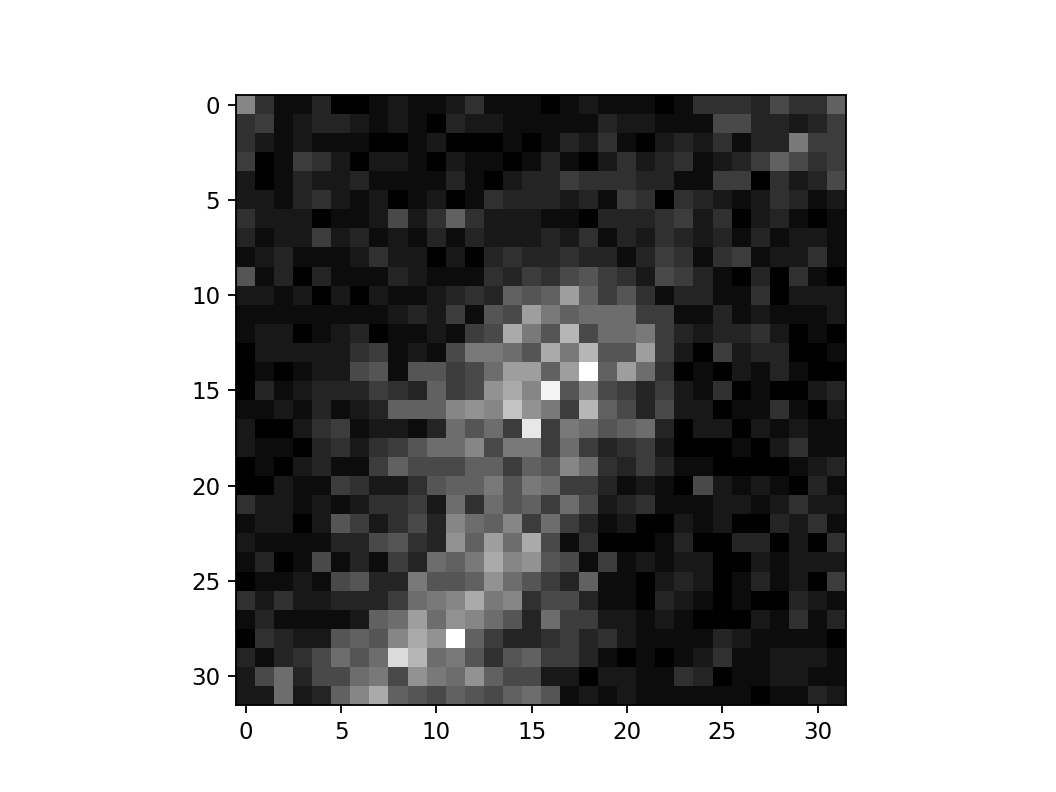

In [30]:
#show an example image

img = my_data[1, 2:]
print(my_data[1,0])
img = np.reshape(img, (7,32,32), order = 'C')
img = img[3]
plt.figure()
plt.imshow(img, cmap = 'gray')

In [31]:
def extract_features(image):
        '''
        # calculate haralick texture features for 4 types of adjacency
        textures = mt.features.haralick(image)
        # take the mean of it and return it
        ht_mean = textures.mean(axis=0)
        textures = np.squeeze(np.reshape(textures, (-1, textures.size)))
        '''   
        img2 = image[1:5, 10:22, 10:22] #center crop of image
        textures2 = mt.features.haralick(img2)
        
        # take the mean of it and return it
        ht_mean2 = textures2.mean(axis=0)
        textures2 = np.squeeze(np.reshape(textures2, (-1, textures2.size)))
        
        #all_textures = np.concatenate([ht_mean, textures2])
        all_textures = textures2
        return all_textures

In [32]:
# loop over the training dataset
train_features = []
train_labels = []
train_ids = []
print("[STATUS] Started extracting haralick textures...")
#for i, row in enumerate(tqdm(my_data)):
for i, row in enumerate(my_data):
        #format image
        img = row[2:]
        mask = img < 0
        img[mask] = img[mask] + 256
        img = np.reshape(img, (7,32,32), order = 'C')
        img = img.astype(int)
        
        label = row[0]
        idnum = row[1]
        #extract features
        features = extract_features(img)
        #save features
        train_features.append(features)
        train_labels.append(label)
        train_ids.append(idnum)

print("[STATUS] Finished extracting haralick textures")

[STATUS] Started extracting haralick textures...
[STATUS] Finished extracting haralick textures


In [33]:

# have a look at the size of our feature vector and labels
print("Training features: {}".format(np.array(train_features).shape))
print("Training labels: {}".format(np.array(train_labels).shape))

Training features: (17244, 169)
Training labels: (17244,)


Total variance explained by 3 components 0.8681888425686819
[0 1]


<IPython.core.display.Javascript object>


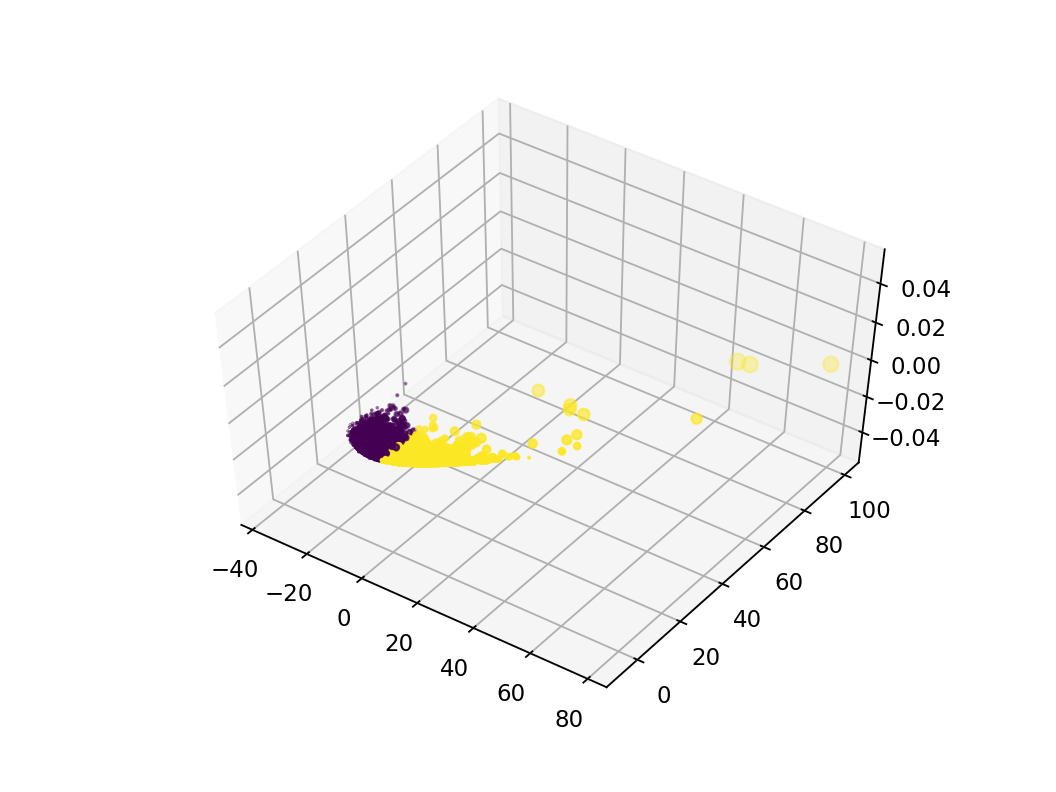

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [37]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

train_features = np.array(train_features)
train_features = StandardScaler().fit_transform(train_features)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(train_features)
print("Total variance explained by 3 components {}".format(np.sum(pca.explained_variance_ratio_)))

kmeans_pred = KMeans(n_clusters=2, random_state=0).fit_predict(train_features)
print(np.unique(kmeans_pred))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:,2], c=kmeans_pred)

<IPython.core.display.Javascript object>


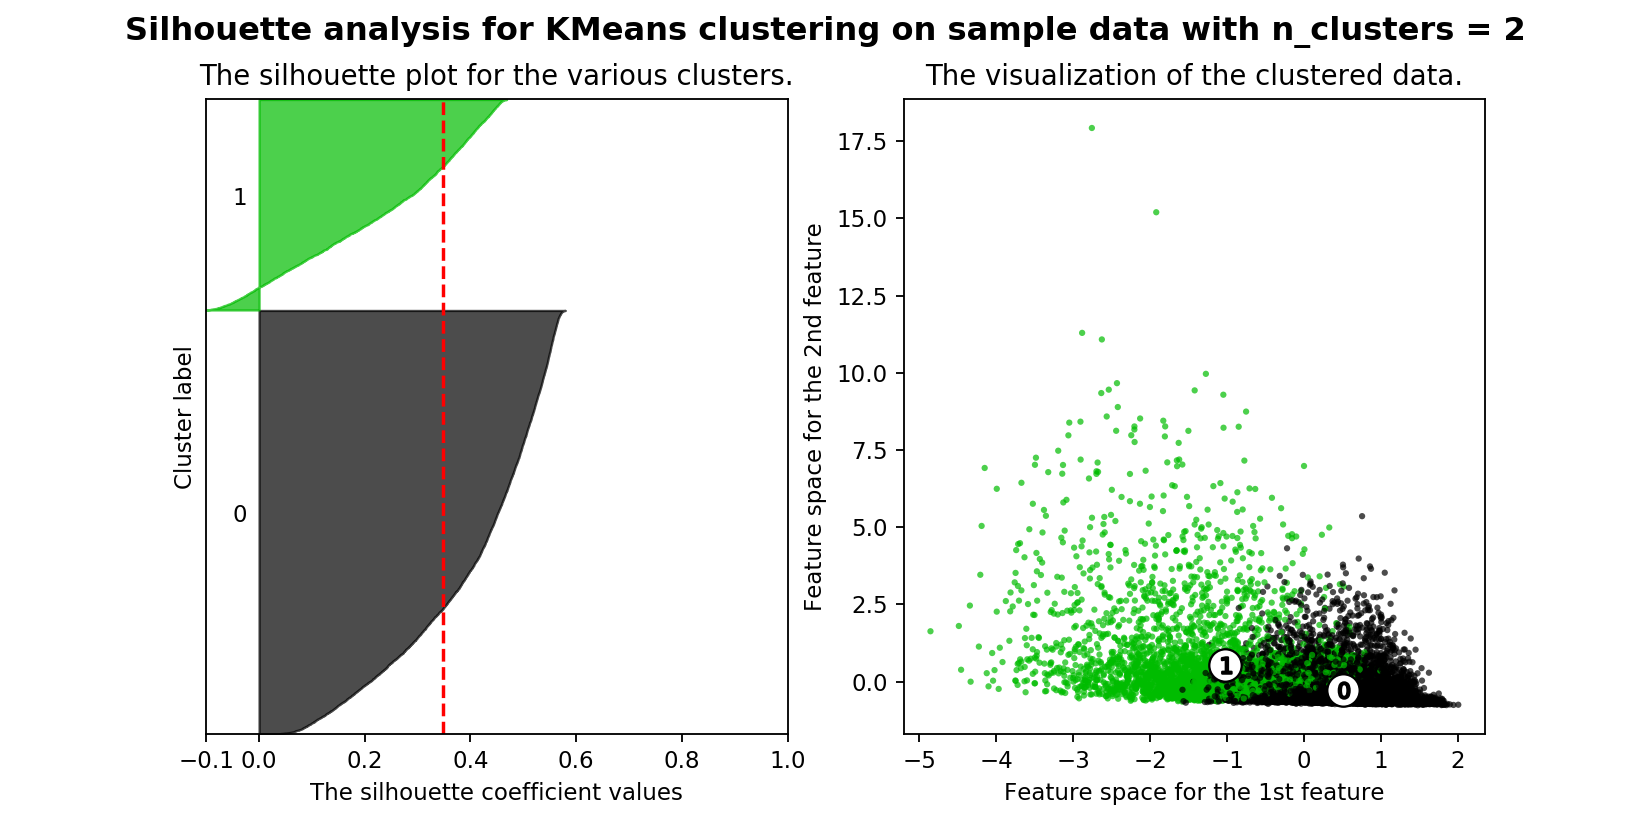

For n_clusters = 2 The average silhouette_score is : 0.34793601688965586


<IPython.core.display.Javascript object>


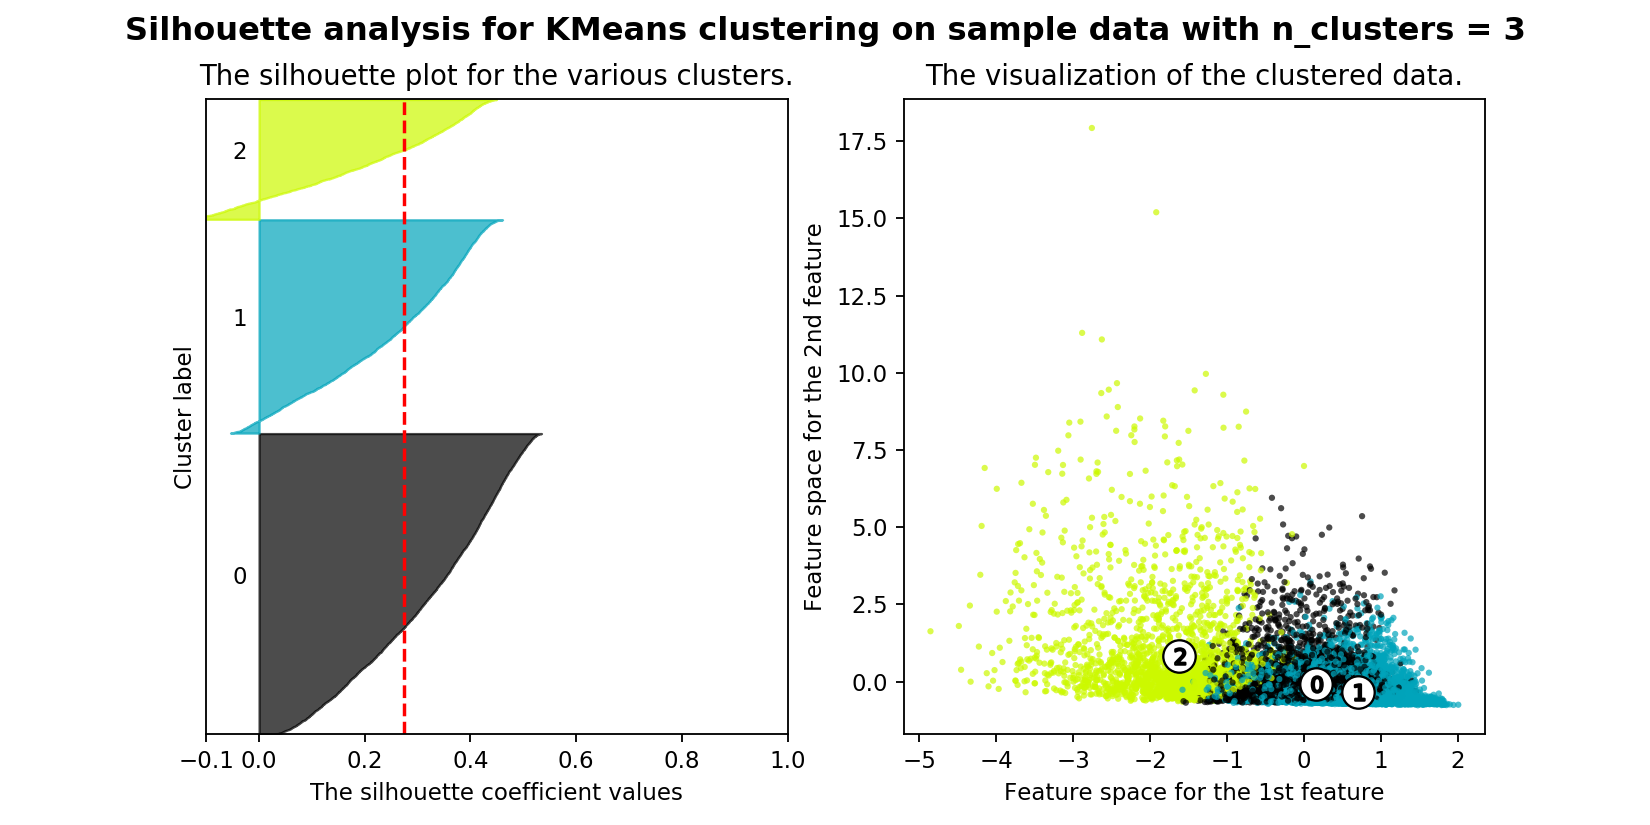

For n_clusters = 3 The average silhouette_score is : 0.2740308204892474


<IPython.core.display.Javascript object>


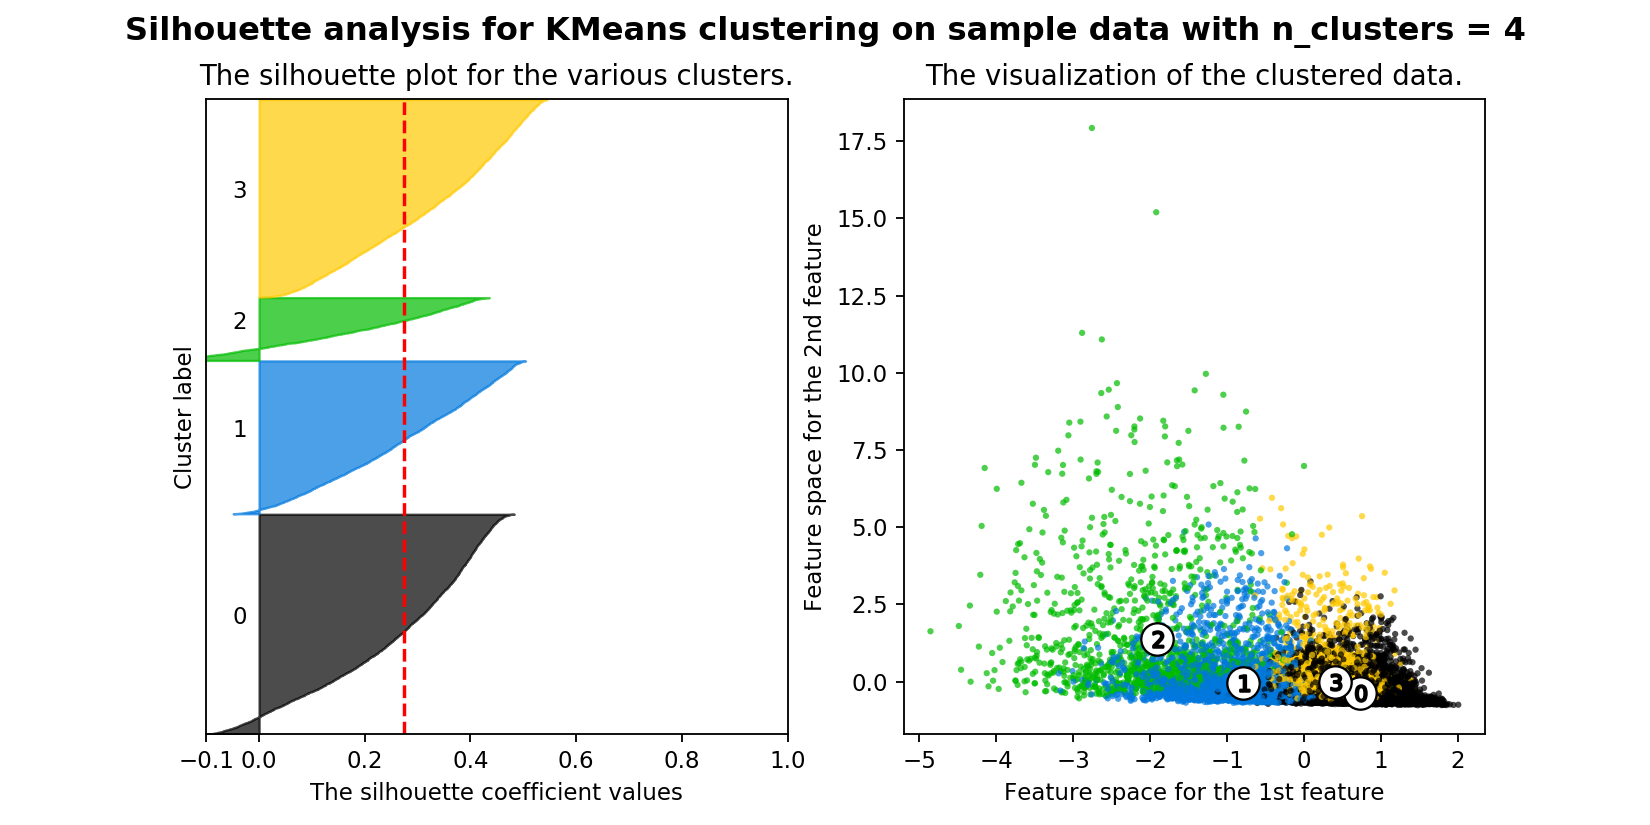

For n_clusters = 4 The average silhouette_score is : 0.27449164918347607


<IPython.core.display.Javascript object>


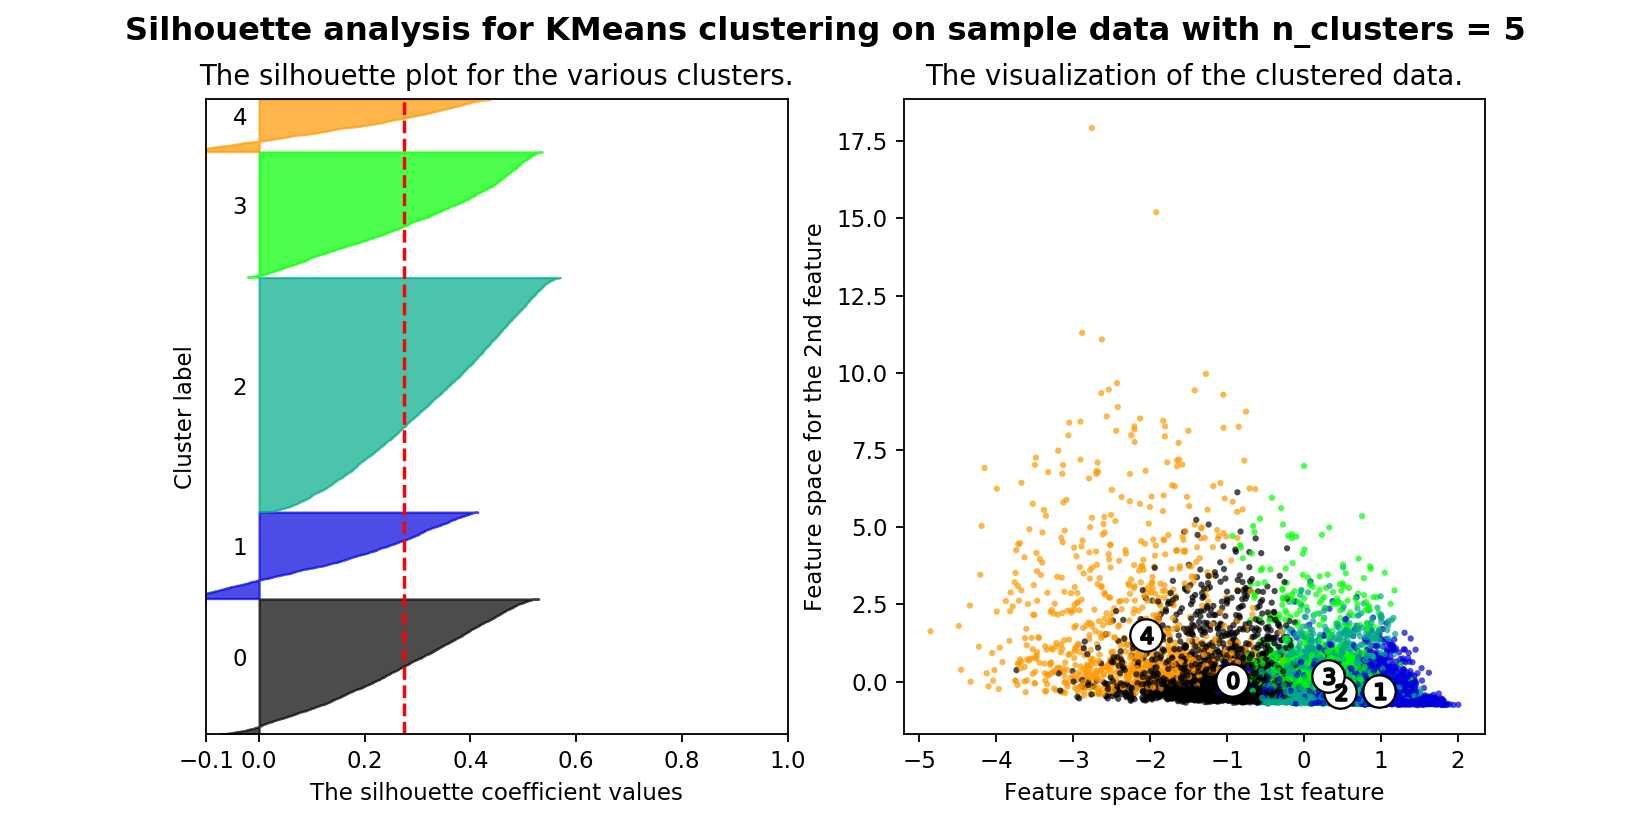

For n_clusters = 5 The average silhouette_score is : 0.2739364870204516


<IPython.core.display.Javascript object>


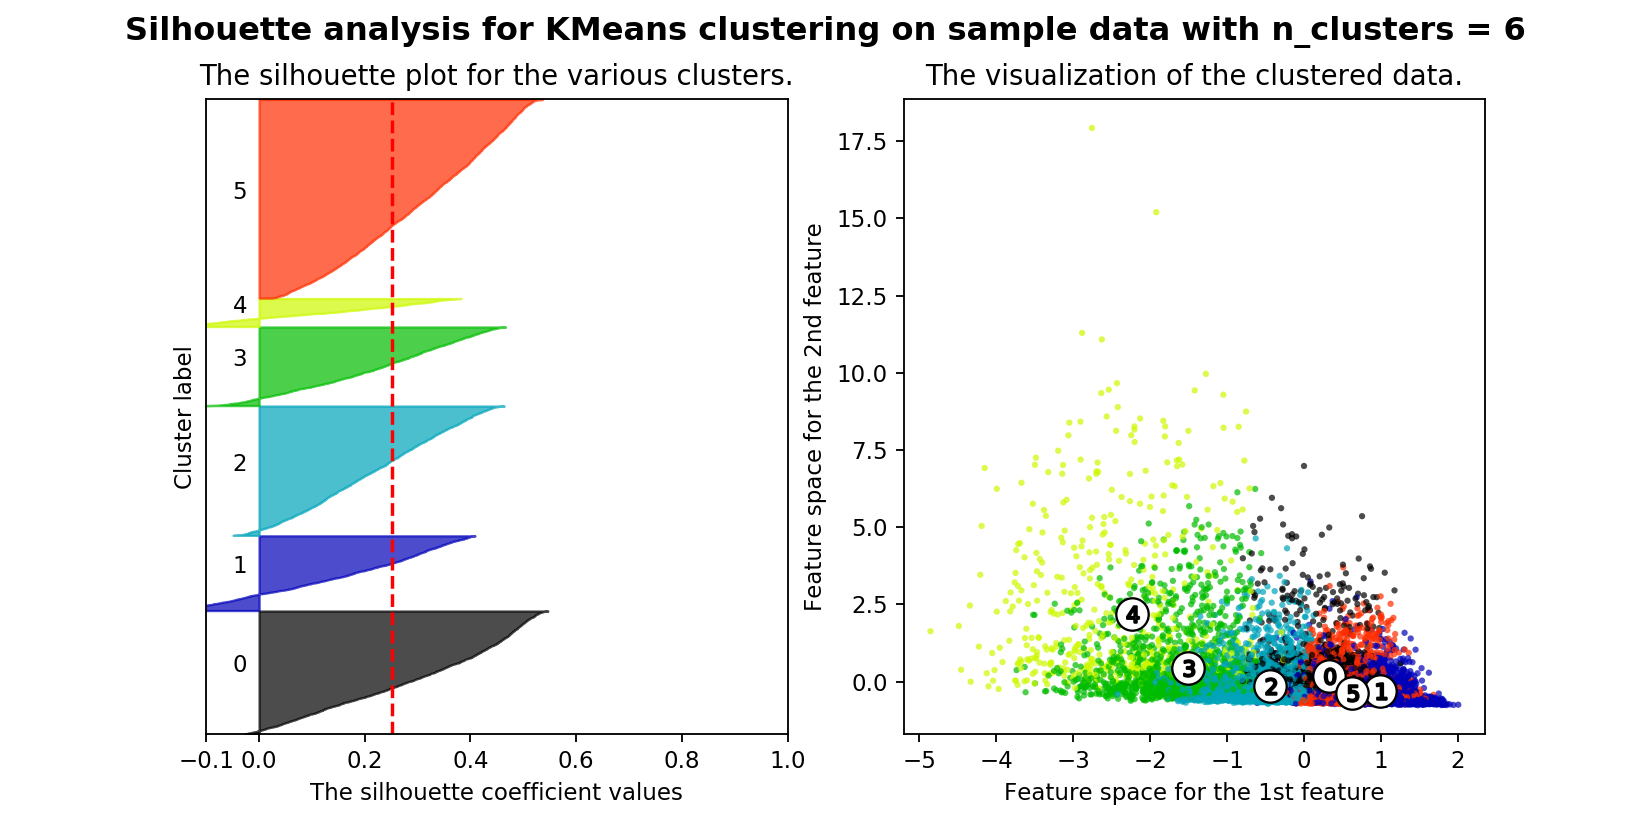

For n_clusters = 6 The average silhouette_score is : 0.2508556245783125


In [189]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

X = train_features

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [46]:
#show some examples of the cluster
def plotExamples(cluster, mycsvdata, label):
    pw = 10
    pl = 10
    cluster_mask = kmeans_pred == label
    mycsvdata_cluster = mycsvdata[cluster_mask, 2:]
    id2show = np.random.choice(len(mycsvdata_cluster), pw*pl,  replace=False)
    imgs = []
    labels = []
    for idx in id2show:
        img = mycsvdata_cluster[idx,:]
        mask = img < 0
        img[mask] = img[mask] + 256
        img = np.reshape(img, (7,32,32), order = 'C')
        img = img[3]
        imgs.append(img)
        labels.append(int(mycsvdata[idx, 0]))
    

    #fig, axs = plt.subplots(pl, pw, figsize=(10,10),facecolor='w', edgecolor='k')
    title = "Cluster: {}".format(label)
    plt.pause(0.1)
    fig, axs = plt.subplots(pl, pw,facecolor='w', edgecolor='k')
    plt.suptitle((title),
                 fontsize=10, fontweight='bold')
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.05, wspace= 0.05)

    for i in range(pw*pl):
        title = "Cluster: {}".format(label)
        axs[i].imshow(imgs[i], cmap = plt.cm.gray)
        #axs[i].set_title(title, fontsize = 5)
        '''
        if labels[i] == 5:
            axs[i].spines['bottom'].set_color('red')
            axs[i].spines['top'].set_color('red')
            axs[i].spines['left'].set_color('red')
            axs[i].spines['right'].set_color('red')
        else:
            axs[i].spines['bottom'].set_color('green')
            axs[i].spines['top'].set_color('green')
            axs[i].spines['left'].set_color('green')
            axs[i].spines['right'].set_color('green')
        '''        
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        
#plotExamples(kmeans_pred, my_data, 0)

<IPython.core.display.Javascript object>


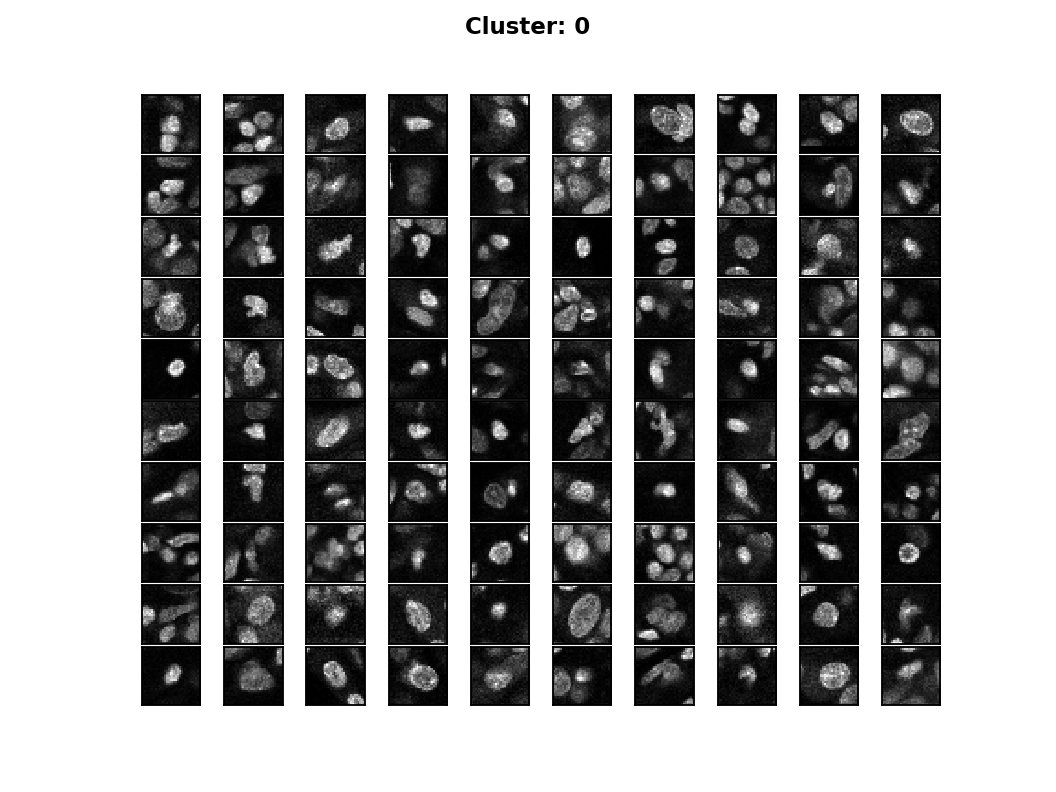

<IPython.core.display.Javascript object>


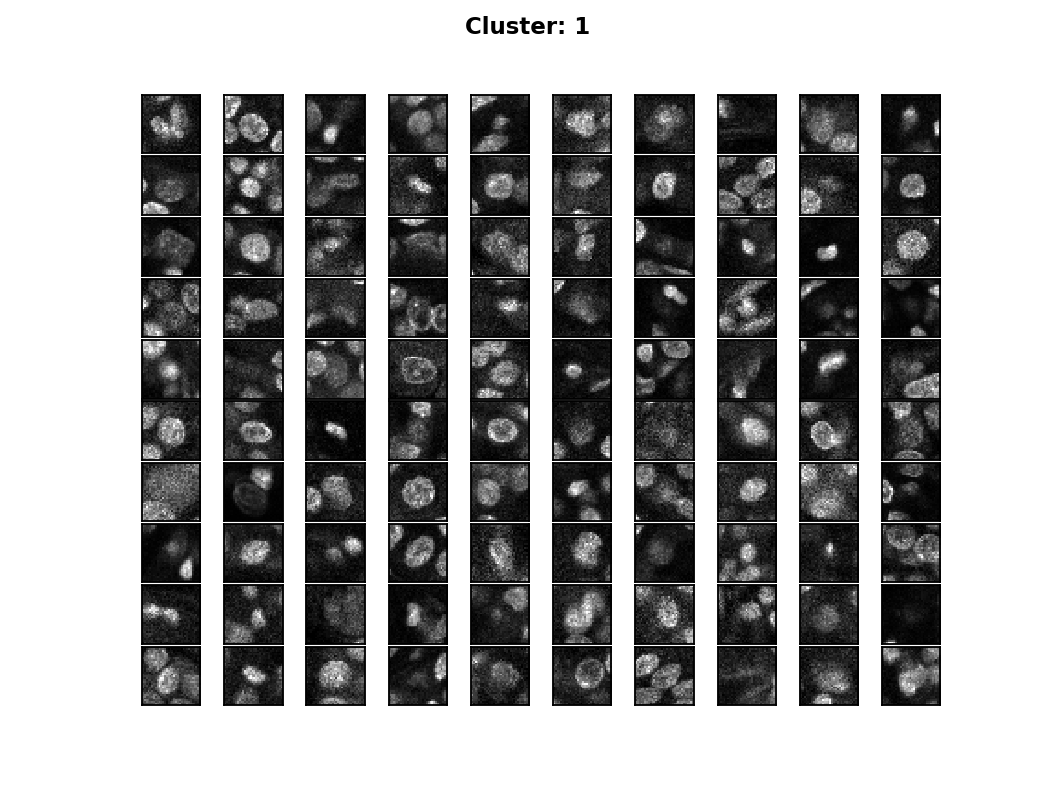

In [47]:
for label in np.unique(kmeans_pred):
    plotExamples(kmeans_pred, my_data, label)